# Accuracy Vs Mag SDSS Spec Test Set

In this notebook we examine the accuracy as a function of magnitude for sources with spectroscopic classifications from SDSS. The SDSS set contains > 3M sources, and, as we will show below, there is a bias towards point sources at the faint end (due to the large number of faint QSOs in the SDSS spectroscopic data). 

This bias suggests that the SDSS `photo` classifications perform better than our new PS1 ML model, however, if we correct for the SDSS bias by selecting bootstrap samples with fewer stars than galaxies at $m > 21$, as is observed in nature at high galactic latitudes, it becomes clear that the ML model greatly outperforms all other available models for star-galaxy separation.

In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
rcParams["font.family"] = "sans-serif"
rcParams['font.sans-serif'] = ['DejaVu Sans']
%matplotlib notebook
from astropy.table import Table
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, accuracy_score, auc, make_scorer

In [32]:
hst_tbl = Table.read("HST_COSMOS_features_adamamiller.fit").to_pandas()
sdss_tbl = Table.read("sdssSP_MLfeats_adamamiller.fit").to_pandas()

For a fair comparison between the 4 models under consideration (the PS1 ML model, the PS1 simple model, the SDSS model, and the PS1 `iPSFMag - iKronMag`) we must generate a subset of sources that has a classification from each model for the test set. Ultimately, the test set has **3592940** sources.

Following Miller+17 we exclude QSOs with $z < 1$ from the test set as many of these sources are AGN with resolved host galaxies (this is 133856 sources total). We also exclude galaxies with $z < 10^{-4}$, which is unphysical and represents spectra with unreliable classifications (this is 13261 sources total).

In [43]:
hst_det = np.where(hst_tbl.nDetections > 0)
sdss_det = np.where(sdss_tbl.nDetections > 0)
sdss_photo_det = np.logical_and(np.isfinite(sdss_tbl.type),
                                sdss_tbl.countRatio > 0)
sdss_in_common = np.logical_and(np.isfinite(sdss_tbl.iPSFminusKron), 
                                sdss_photo_det)
low_z_gal = np.logical_and(sdss_tbl.z < 1e-4, sdss_tbl['class'] == 'GALAXY')
low_z_qso = np.logical_and(sdss_tbl.z < 1, sdss_tbl['class'] == '   QSO')

sdss_test_set = sdss_in_common & ~low_z_gal & ~low_z_qso

Train the ML model to provide classifications for the sources with SDSS spectra.

In [47]:
features = ['wwApFlux', 'wwPSFFlux', 'wwKronFlux', 
            'wwpsfChiSq', 'wwExtNSigma', 'wwpsfLikelihood',
            'wwPSFKronRatio', 'wwPSFKronDist',  'wwPSFApRatio',
            'wwmomentRH', 'wwmomentXX', 'wwmomentXY', 'wwmomentYY', 
            'wwKronRad']

In [49]:
hst_ml_train_X = hst_tbl[features].ix[hst_det]
hst_ml_train_y = hst_tbl["MU_CLASS"].ix[hst_det] - 1
sdss_ml_test_X = sdss_tab[features].ix[sdss_test_set]
sdss_spec_class = sdss_tbl['class'].ix[sdss_test_set]
sdss_ml_test_y = np.ones_like(sdss_spec_class)
sdss_ml_test_y[np.where(sdss_spec_class == "GALAXY")] = 0

In [50]:
rf_clf = RandomForestClassifier(n_estimators = 250, min_samples_leaf = 1, max_features= 5, n_jobs=-1)
rf_clf.fit(hst_ml_train_X, hst_ml_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
sdss_preds = rf_clf.predict_proba(sdss_ml_test_X)

## Compare the ROC curves of the different models

In [52]:
ml_fpr, ml_tpr, ml_thresh = roc_curve(sdss_ml_test_y, sdss_preds[:,1])
sdss_fpr, sdss_tpr, sdss_thresh = roc_curve(sdss_ml_test_y, sdss_tab["countRatio"].ix[sdss_test_set])
simple_fpr, simple_tpr, simple_thresh = roc_curve(sdss_ml_test_y, sdss_tab["wwPSFKronDist"].ix[sdss_test_set])
ps1_fpr, ps1_tpr, ps1_thresh = roc_curve(sdss_ml_test_y, -1.*sdss_tab["iPSFminusKron"].ix[sdss_test_set])

<IPython.core.display.Javascript object>


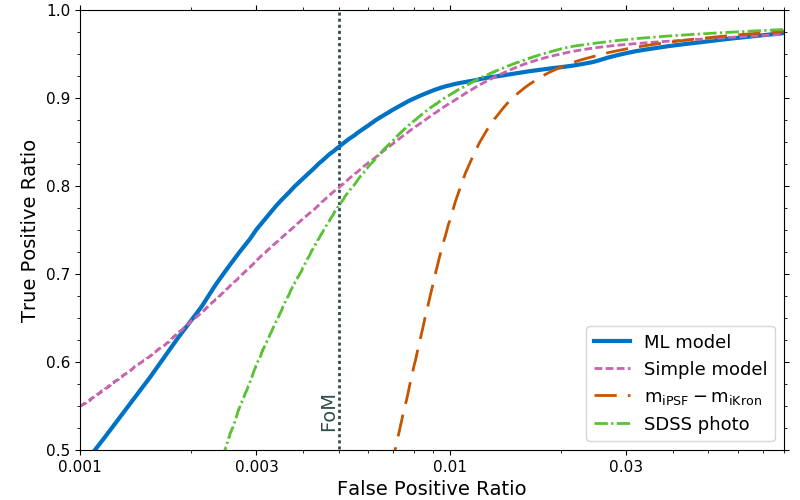

In [117]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

color_dict = {'ml': "#0072c6", #"#1C1858",
              'sdss': "#5BC236", #"#00C78E",
              'simple': "#C864AF", #"#C70039",
              'ps1': "#C65400"}

fig, ax = plt.subplots(figsize=(8, 5))

ax.tick_params(which="both", top=True, right=True)

ax.plot(ml_fpr, ml_tpr, 
        color=color_dict['ml'], label='ML model', lw=3)
ax.plot(simple_fpr, simple_tpr,
        ls = '--', lw=2,
        color=color_dict['simple'], label='Simple model')
ax.plot(ps1_fpr, ps1_tpr,
        ls = '--', lw=2, dashes=(8, 4),
        color=color_dict['ps1'], label=r'm$_{\rm iPSF}-$m$_{\rm iKron}$')
ax.plot(sdss_fpr, sdss_tpr,
        ls = '-.', lw=2,
        color=color_dict['sdss'], label='SDSS photo')
# ax.plot(sdss_fpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], 
#         sdss_tpr[np.argmin(np.abs(sdss_thresh-10**(-0.185/2.5)))], '*', color="black")
ax.vlines([5e-3], 1e-3, 1, 
          linestyles=":", 
          color='DarkSlateGrey', lw=2)
ax.text(5e-3, 0.55, 'FoM', 
        color='DarkSlateGrey', 
        rotation=90, ha="right", fontsize=14)

ax.set_ylim(0.5, 1)
ax.set_xlim(1e-3, 8e-2)
ax.set_xscale("log")
ax.tick_params(labelsize = 11)
ax.set_xlabel('False Positive Ratio', fontsize=14)
ax.set_ylabel('True Positive Ratio', fontsize=14)

ax.set_xticks([1e-3, 3e-3, 1e-2, 3e-2])
ax.set_xticklabels([1e-3, 3e-3, 1e-2, 3e-2])
ax.yaxis.set_minor_locator(MultipleLocator(0.025))

ax.legend(loc=4, fontsize=13)

fig.subplots_adjust(top=0.98,right=0.98,left=0.1,bottom=0.1)
# fig.savefig('~/Desktop/ROC_sdss_spec.png')
# fig.savefig('ROC_sdss_spec.pdf')

Using the SDSS spectroscopic sample as a test set it is clear that the ML model provides the best FoM. However, at $\mathrm{FPR} \approx 0.015$ each of the 3 other models cross over the ML model ROC curve and provide a better performance. This is coupled with an unusual kink at $\mathrm{FPR} \approx 0.025$ that suggests something unusual is going on.

In [118]:
import seaborn as sns

<IPython.core.display.Javascript object>


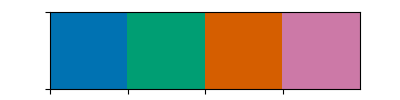

In [125]:
sns.palplot(sns.color_palette("colorblind", 4))